# Cross-fold validation

Demonstration of different CV techniques, and when to use them.

Overview of techniques presented.

- Hold-out validation (K=1)
- K-fold cross validation
- Leave-one-out CV (K=N)
- K-fold variations
  - Leave-p-out CV
  - Stratified K-fold for classification
  - Repeated K-fold
- Nested K-fold for hyperparameter optimization

References used.

- https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right
- https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
- https://machinelearningmastery.com/different-results-each-time-in-machine-learning/
- https://scikit-learn.org/stable/modules/grid_search.html#grid-search

## Imports

In [1]:
# manual nested cross-validation for random forest on a classification dataset
import typing
import time
import timeit
import functools
from collections import Counter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.figure

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection._split import BaseCrossValidator
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, LeaveOneOut, LeavePOut

from sklearn.model_selection._search import BaseSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error 

## Helpers

In [16]:
def get_superclasses(cls:type):
    import inspect
    return inspect.getmro(cls)    

In [2]:
def timeit_decorator(func):
    """decorator to measure execution time.
    
    reference: https://dev.to/kcdchennai/python-decorator-to-measure-execution-time-54hk
    """
    @functools.wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [4]:
def conditional_decorator(dec, condition):
    """Wrap another decorator to add a conditional whether to use it or not.
    
    reference: https://stackoverflow.com/a/10724898/8116031
    
    >>> condition = decide()
    >>>
    >>> @conditional_decorator(timeit_decorator, condition):
    >>> def foo():
    >>>   time.sleep(2) 
    >>> foo()    
    """
    def decorator(func):
        if not condition:
            # Return the function unchanged, not decorated.
            return func
        return dec(func)
    return decorator

In [2]:
def get_closest_value_index(array : np.ndarray, value : float) -> int:
    """Find index of nearest value in numpy array.
    
    Reference: https://stackoverflow.com/a/2566508/8116031
    """
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

def get_closest_value(array : np.ndarray, value : float) -> float:
    """Find nearest value in numpy array.
    
    Reference: https://stackoverflow.com/a/2566508/8116031
    """
    idx = get_closest_value_index(array, value)
    return array[idx]

In [3]:
def index_1d_to_2d(i:int,width:int) -> (int,int):
    # reference: https://softwareengineering.stackexchange.com/a/212813
    y = i % width    # % is the "modulo operator", the remainder of i / width;
    x = i // width   # where "//" is an integer division    
    return x,y
def index_2d_to_1d(x:int,y:int,width:int) -> int:
    # reference: https://softwareengineering.stackexchange.com/a/212813
    return x + width*y
def index_3d_to_1d(x:int,y:int,z:int,width:int,height:int) -> int:
    # reference: https://softwareengineering.stackexchange.com/a/212813
    return  x + width*y + width*height*z
def index_1d_to_3d(i:int,width:int,height:int) -> (int,int,int):
    # reference: https://softwareengineering.stackexchange.com/a/212813
    z = i % width
    y = (i // width)%height
    x = i // (width*height)
    return x,y,z

def index_range_1d_to_nd(idx_range_1d:list, nd_idx_shape:tuple) -> typing.List[typing.Tuple[int]]:
    """Turn 1D indices into nD indices.
    
    >>> index_1d_to_nd(range(4), (2,2))
        [array([0, 0]), array([0, 1]), array([1, 0]), array([1, 1])]
    """
    idx_range_nd = list(np.array(np.unravel_index(idx_range_1d, nd_idx_shape)).transpose())
    return [tuple(idx) for idx in idx_range_nd]

In [5]:
def parity_plot_kfold(models: typing.List[BaseEstimator], 
                      Xy_test : typing.Tuple[np.ndarray],
                      kfold_cls : type = KFold,                      
                      test_size : float = 0.2,
                      metrics : typing.List[str] = None,
                      name:str = "", unit:str = "",
                      fig : mpl.figure.Figure = None, ax : mpl.axes.Axes = None,
                      display_plot:bool = True) -> mpl.figure.Figure:
    """Make parity plot figure for k-fold cross-validated sequence of models.
    
    :param models: k scikit-learn models (estimators).
    :param Xy_test: tuple (X_test, y_test).
    :param test_size: test split size in (0,1) used for plotting the parity plot, not necessarily for training (eg when using same Xy for comparing different plots, or for LOOCV).
    :param metrics: metrics to print in title. All: ['r^2', 'mae', 'rmse', 'mse' 'mape']. None = default: ['r2', 'mae'].
    :param name: Optional target property y name.
    :param unit: Optional target property y unit.
    :param fig: Optional figure to use for drawing (eg, for subplots).
    :param ax: Optiional axes to use for drawing (eg, for subplots).
    :param display_plot: True: display plot on return. False: Return figure without plotting.
    :return: matplotlib figure.
    """
    if not display_plot:
        # Turn interactive plotting off
        plt.ioff()    
    
    # if only one model given, put in list
    if not isinstance(models, list):
        models = [models]
    # get k of k-fold CV
    num_iter = len(models)
    
    # check metrics    
    valid_metrics = [
        'r^2', 
        'mae', 
        'rmse', 
        'mse', 
        'mape'
    ]
    default_metrics = ['r^2', 'mae']    
    valid_metric_funs = {
        'r^2' : r2_score,
        'mae' : mean_absolute_error,
        'rmse' : mean_squared_error,
        'mse' : mean_squared_error,
        'mape' : mean_absolute_percentage_error
    }
    valid_metric_kwargs = {
        'r^2' : dict(),
        'mae' : dict(),
        'rmse' : {'squared' : False},
        'mse' : dict(),
        'mape' : dict()
    }
    
    if not metrics:
        metrics = default_metrics        
    if any(m not in valid_metrics for m in metrics):
        print(f"Warning: Specified {metrics=}, not a subset of {valid_metrics=}. I will ignore the invalid ones.")
        metrics = [m for m in metrics if m in valid_metrics]
    if not metrics:
        metrics = default_metrics    
        
    metric_funs = {m : valid_metric_funs[m] for m in metrics}
    metric_kwargs = {m : valid_metric_kwargs[m] for m in metrics}

    # calc mean scores
    X_test, y_test = Xy_test
    
    # sort by y size
    y_test, X_test = (list(t) for t in zip(*sorted(zip(y_test, X_test))))
    
    y_preds = [model.predict(X_test) for model in models]
    y_preds_mean = np.mean(np.array(y_preds), axis=0)
    y_preds_std = np.std(np.array(y_preds), axis=0)
    
    metrics_latex = {m : '$\overline{\mathrm{'+m.upper()+'}}$' for m in metrics} if num_iter > 1 \
                    else {m : '$\mathrm{'+m.upper()+'}$' for m in metrics}
    
    all_scores = {m : [m_fun(y_test, y_pred, **m_kwargs) for y_pred in y_preds] \
                  for (m, m_fun), (m, m_kwargs) \
                  in zip(metric_funs.items(), metric_kwargs.items())}

    # To get the final score average the results that you got on step 6.    
    agg_funs = {
        # 'k' : np.count_nonzero,
        'mean' : np.mean,
        'std' : np.std,
    }
    score_stats = {m : {agg : agg_fun(scores) \
                        for agg, agg_fun in agg_funs.items()} \
                   for m, scores in all_scores.items()}
    
    # get default color cycle to match scatter, errorbar, fill_between to same color, vs. y=x perfect model performance
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    color1 = colors[0]
    color2 = colors[1]
    
    # Plot parity and score stats
    if not ax:
        fig, ax = plt.subplots()
    
    ax.scatter(y_test, y_preds_mean, color=color1)
    ax.errorbar(y_test, y_preds_mean, y_preds_std, color=color1) # not working correctly or applicable here
    ax.fill_between(y_test, y_preds_mean - y_preds_std, y_preds_mean + y_preds_std, color=color1, alpha=0.2) # not working correctly or applicable here
    # plot x=y perfect model comparison line
    ax.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], color=color2)
    
    score_strings = {m : f"{metrics_latex[m]} = ${stat['mean']:.2f} \pm {stat['std']:.2f}$ {unit}" \
                     for m, stat in score_stats.items()}
    # for MAPE, unit should be '%', though ...
    if 'mape' in score_strings:
        m = 'mape'
        stat = score_stats[m]
        score_strings[m] = f"{metrics_latex[m]} = ${100 * stat['mean']:.2f} \pm {100 * stat['std']:.2f}$ %"
    
    # add subtitles
    kfold_name = kfold_cls.__name__ if kfold_cls else "Hold-out validation"
    title = f"{kfold_name} validation, {num_iter=}, (plot {100*test_size:.0f} % of dataset)"
    
    # subtitles 1: score statistics
    score_strings = list(score_strings.values())
    # add line break if more than 3 scores
    if len(score_strings) > 3:
        score_strings[2] += '\n'
    score_line = ", ".join(score_strings)
    title += "\n" + ", ".join(score_strings)
    
    # subtitles 2: model counts by type
    # (note: sklearn str(model) adds '()' to end, remove with [:-2])
    if num_iter > 1:
        model_names = [str(m)[:-2] for m in models]
        model_counter = Counter(model_names)
        models_count = ", ".join([f"{mname}: {mcount}" for mname, mcount in model_counter.most_common()])
        title += f"\nModels: " + models_count
    else:
        title += f"\nModel: " + str(models[0])[:-2]
    
    
    # plot subtitles
    ax.set_title(title)
    
    # name = name if name else "$y$"
    ax.set_xlabel(f"True {name} {unit}")
    ax.set_ylabel(f"Predicted {name} {unit}")
    if fig:
        fig.tight_layout()
    return fig

## Global variables

In [6]:
# store figures for creating subplots. key = n_splits, value = figure
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,16))

In [7]:
# dataset
n_samples=100
n_features=100
X, y = make_regression(n_samples, n_features)

In [8]:
# test size
test_size = 0.2
plot_test_size = 0.2

Note: When matplotlib warns of 'too many figures open', just call `plt.close('all')`.

## Hold-out cross-validation

K-fold CV with k=1.

![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Cross-validation-hold-out.jpg?resize=525%2C225&ssl=1)

In [9]:
def make_example_hold_out_validation(X, y, test_size=0.2, plot_test_size=0.2,
                                     fig=None, ax=None, display_plot=False, **kwargs) -> matplotlib.figure.Figure:

    # 1. Divide the dataset into two parts: the training set and the test set. Usually, 
    # 80% of the dataset goes to the training set and 20% to the test set but you may 
    # choose any splitting that suits you better
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=111)

    # 2. Train the model on the training set
    model = LinearRegression().fit(X_train, y_train)

    # 3. Validate on the test set
    # for plotting purposes and comparison of methods, instead set a fixed test set size
    _, X_test_pp, _, y_test_pp = train_test_split(X, y, test_size=test_size)
    return parity_plot_kfold(model, (X_test_pp, y_test_pp), kfold_cls=None, test_size=plot_test_size, fig=fig, ax=ax, display_plot=display_plot, **kwargs)
    # return parity_plot_kfold(model, (X_test, y_test), fig=fig, ax=ax, display_plot=display_plot, **kwargs)

In [10]:
fig = make_example_hold_out_validation(X, y, test_size=test_size, plot_test_size=plot_test_size, fig=fig, ax=axs[0,0], display_plot=False)

## k-Fold cross-validation

For sklearn, note that `KFold(n_splits=n_samples)` does not work. For that, use LOOCV class `LeaveOneOut` instead.

![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Cross-validation-k-fold.jpg?resize=525%2C525&ssl=1)

In [11]:
def make_example_k_fold_cv(X, y, n_splits=5, test_size=0.2, plot_test_size=0.2, 
                           repeated=False,  n_repeats=5, stratified=False, 
                           display_plot=False, fig=None, ax=None, verbosity:int=2, **kwargs) -> matplotlib.figure.Figure:

    # 1. Pick a number of folds – k. Usually, k is 5 or 10 but you can choose any number which is less than the dataset’s length.
    kfold_classes = {
        (False, False) : KFold,
        (True, False) : RepeatedKFold,
        (False, True) : StratifiedKFold,
        (True, True) : RepeatedStratifiedKFold
    }
    kfold_kwargs_by_cls = {
        KFold : dict(n_splits=n_splits),
        RepeatedKFold : dict(n_splits=n_splits, n_repeats=n_repeats),
        StratifiedKFold : dict(n_splits=n_splits),
        RepeatedStratifiedKFold : dict(n_splits=n_splits, n_repeats=n_repeats),
    }
    kfold_cls = kfold_classes[(repeated, stratified)]
    kfold_kwargs = kfold_kwargs_by_cls[kfold_cls]
    kfold = kfold_cls(**kfold_kwargs)
    num_iter = kfold.get_n_splits(X,y)
    
    if verbosity > 0:
        print(f"\nStarting {kfold_cls.__name__} (cross) validation, args: {kfold_kwargs}, will run {num_iter=} iterations ...")    

    models = []
    r2_scores = []
    ma_errors = []
    map_errors = []

    # 2. Split the dataset into k equal (if possible) parts (they are called folds)
    # 7. Repeat steps 3 – 6 k times. Each time use the remaining  fold as the test set. 
    #    In the end, you should have validated the model on every fold that you have.
    for k, indices in enumerate(kfold.split(X,y)):

        # 3. Choose k – 1 folds as the training set. The remaining fold will be the test set
        train_indices, test_indices = indices
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # 4. Train the model on the training set. On each iteration of cross-validation, 
        # you must train a new model independently of the model trained on the previous iteration
        models.append(LinearRegression().fit(X_train, y_train))

        # 5. Validate on the test set
        # 6. Save the result of the validation
        # scores.append(models[-1].score(X_test, y_test))
        # Do that in parity_plot instead

        if verbosity > 1:
            print(f"split {k=}, train range {train_indices[0]}..{train_indices[-1]}, test range {test_indices[0]}..{test_indices[-1]}.")

    # 3. Validate on the test set
    # for plotting purposes and comparison of methods, instead set a fixed test set size
    _, X_test_pp, _, y_test_pp = train_test_split(X, y, test_size=test_size)
    
    if verbosity > 0:
        print("Done.")    
    
    return parity_plot_kfold(models, (X_test_pp, y_test_pp), kfold_cls=kfold_cls, test_size=plot_test_size, fig=fig, ax=ax, display_plot=display_plot, **kwargs)
    # return parity_plot_kfold(models, (X_test, y_test), fig=fig, ax=ax, display_plot=display_plot, **kwargs)    

In [12]:
idx_range_2d = index_range_1d_to_nd(range(1,5), (3,2))
for i, n_splits in enumerate([2,5,10,50]):
    row,col = idx_range_2d[i]
    fig = make_example_k_fold_cv(X, y, n_splits=n_splits, test_size=test_size, plot_test_size=plot_test_size, display_plot=False, fig=fig, ax=axs[row,col])


Starting KFold (cross) validation, args: {'n_splits': 2}, will run num_iter=2 iterations ...
split k=0, train range 50..99, test range 0..49.
split k=1, train range 0..49, test range 50..99.
Done.

Starting KFold (cross) validation, args: {'n_splits': 5}, will run num_iter=5 iterations ...
split k=0, train range 20..99, test range 0..19.
split k=1, train range 0..99, test range 20..39.
split k=2, train range 0..99, test range 40..59.
split k=3, train range 0..99, test range 60..79.
split k=4, train range 0..79, test range 80..99.
Done.

Starting KFold (cross) validation, args: {'n_splits': 10}, will run num_iter=10 iterations ...
split k=0, train range 10..99, test range 0..9.
split k=1, train range 0..99, test range 10..19.
split k=2, train range 0..99, test range 20..29.
split k=3, train range 0..99, test range 30..39.
split k=4, train range 0..99, test range 40..49.
split k=5, train range 0..99, test range 50..59.
split k=6, train range 0..99, test range 60..69.
split k=7, train ra

## Leave-one-out cross-validation (LOOCV)

k-fold CV with k=n, n = num. samples.

![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Cross-validation-leave-one-out.jpg?resize=564%2C440&ssl=1)

In [13]:
def make_example_leave_one_out_validation(X, y, test_size=0.2, plot_test_size=0.2,
                                          display_plot=False, fig=None, ax=None, silent=False, **kwargs) -> matplotlib.figure.Figure:
    n_splits = n_samples
    if not silent:
        print(f"\n Leave-One-Out- cross validation, {n_splits=}")

    # 1. Pick a number of folds – k. Usually, k is 5 or 10 but you can choose any number which is less than the dataset’s length.
    kf = LeaveOneOut()

    models = []
    r2_scores = []
    ma_errors = []
    map_errors = []

    # 2. Split the dataset into k equal (if possible) parts (they are called folds)
    # 7. Repeat steps 3 – 6 k times. Each time use the remaining  fold as the test set. 
    #    In the end, you should have validated the model on every fold that you have.
    for k, indices in enumerate(kf.split(X)):

        # 3. Choose k – 1 folds as the training set. The remaining fold will be the test set
        train_indices, test_indices = indices
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # 4. Train the model on the training set. On each iteration of cross-validation, 
        # you must train a new model independently of the model trained on the previous iteration
        models.append(LinearRegression().fit(X_train, y_train))

        # 5. Validate on the test set
        # 6. Save the result of the validation
        # scores.append(models[-1].score(X_test, y_test))
        # Do that in parity_plot instead

        if not silent:
            print(f"split {k=}, train range {train_indices[0]}..{train_indices[-1]}, test range {test_indices[0]}..{test_indices[-1]}.")

    # 3. Validate on the test set
    # for plotting purposes and comparison of methods, instead set a fixed test set size
    _, X_test_pp, _, y_test_pp = train_test_split(X, y, test_size=test_size)
    return parity_plot_kfold(models, (X_test_pp, y_test_pp), kfold_cls=type(kf), test_size=plot_test_size, fig=fig, ax=ax, display_plot=display_plot, **kwargs)
    # return parity_plot_kfold(models, (X_test, y_test), fig=fig, ax=ax, display_plot=display_plot, **kwargs)

In [14]:
fig = make_example_leave_one_out_validation(X, y, test_size=test_size, plot_test_size=plot_test_size, fig=fig, ax=axs[2,1], display_plot=False)


 Leave-One-Out- cross validation, n_splits=100
split k=0, train range 1..99, test range 0..0.
split k=1, train range 0..99, test range 1..1.
split k=2, train range 0..99, test range 2..2.
split k=3, train range 0..99, test range 3..3.
split k=4, train range 0..99, test range 4..4.
split k=5, train range 0..99, test range 5..5.
split k=6, train range 0..99, test range 6..6.
split k=7, train range 0..99, test range 7..7.
split k=8, train range 0..99, test range 8..8.
split k=9, train range 0..99, test range 9..9.
split k=10, train range 0..99, test range 10..10.
split k=11, train range 0..99, test range 11..11.
split k=12, train range 0..99, test range 12..12.
split k=13, train range 0..99, test range 13..13.
split k=14, train range 0..99, test range 14..14.
split k=15, train range 0..99, test range 15..15.
split k=16, train range 0..99, test range 16..16.
split k=17, train range 0..99, test range 17..17.
split k=18, train range 0..99, test range 18..18.
split k=19, train range 0..99, t

## Plot hold-out, k-fold, LOOCV

This plot shows the *averaged* predictions and scores for each validation technique. Naturally, more splits (folds) lead to lower *averaged* errors. 

In [15]:
# finally, show the figure
# (1x hold-out, 4x k-fold, 1x LOOCV = 6 subplots)
# fig.suptitle(f"Comparison of hold-out (k=1), k-fold CV, LOOC (k=n), n={n_samples}")
fig

## k-fold variations

### Leave-p-out cross-validation

Extension of LOOCV, only for small datasets, number of splits grows combinatorily.

In [16]:
print(f"Leave-p-out CV, number of splits, for {n_samples=}:")
for p in [0,1] + list(range(2,11,2)):
    print(f"{p=}, number of splits = {LeavePOut(p).get_n_splits(X,y):.2e}")

Leave-p-out CV, number of splits, for n_samples=100:
p=0, number of splits = 1.00e+00
p=1, number of splits = 1.00e+02
p=2, number of splits = 4.95e+03
p=4, number of splits = 3.92e+06
p=6, number of splits = 1.19e+09
p=8, number of splits = 1.86e+11
p=10, number of splits = 1.73e+13


### Stratified k-Fold cross-validation

k-fold CV for imbalanced (target) datasets.

> It works as follows. Stratified k-Fold splits the dataset on k folds such that each fold contains approximately the same percentage of samples of each target class as the complete set. In the case of regression, Stratified k-Fold makes sure that the mean target value is approximately equal in all the folds.

sklearn `StratifiedKFold` supports only classification (discrete target), no regression (continuous target).

### Repeated k-Fold cross-validation

Like K-fold, but instead of contiguous splits, do k random samples. Pro: test size independent of K. Contra: Sampling may leave out / sample multiple times part of the data.

As plot below shows, repeated k-fold has quadratic cost of k-fold for n_repeats==n_splits, but no visible accuracy advantage.

![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/cross-validation-repeated.jpg?resize=525%2C525&ssl=1)

In [17]:
idx_range_2d = index_range_1d_to_nd(range(6), (3,2))
idx_kfold = idx_range_2d[0::2]
idx_rkfold = idx_range_2d[1::2]

In [18]:
for i, n_splits in enumerate([2,5,50]):
    row,col = idx_kfold[i]
    fig = make_example_k_fold_cv(X, y, n_splits=n_splits, repeated=False, test_size=test_size, plot_test_size=plot_test_size, display_plot=False, fig=fig, ax=axs[row,col], verbosity=1)
    row,col = idx_rkfold[i]
    fig = make_example_k_fold_cv(X, y, n_splits=n_splits, repeated=True, n_repeats=n_splits, test_size=test_size, plot_test_size=plot_test_size, display_plot=False, fig=fig, ax=axs[row,col], verbosity=1)


Starting KFold (cross) validation, args: {'n_splits': 2}, will run num_iter=2 iterations ...
Done.

Starting RepeatedKFold (cross) validation, args: {'n_splits': 2, 'n_repeats': 2}, will run num_iter=4 iterations ...
Done.

Starting KFold (cross) validation, args: {'n_splits': 5}, will run num_iter=5 iterations ...
Done.

Starting RepeatedKFold (cross) validation, args: {'n_splits': 5, 'n_repeats': 5}, will run num_iter=25 iterations ...
Done.

Starting KFold (cross) validation, args: {'n_splits': 50}, will run num_iter=50 iterations ...
Done.

Starting RepeatedKFold (cross) validation, args: {'n_splits': 50, 'n_repeats': 50}, will run num_iter=2500 iterations ...
Done.


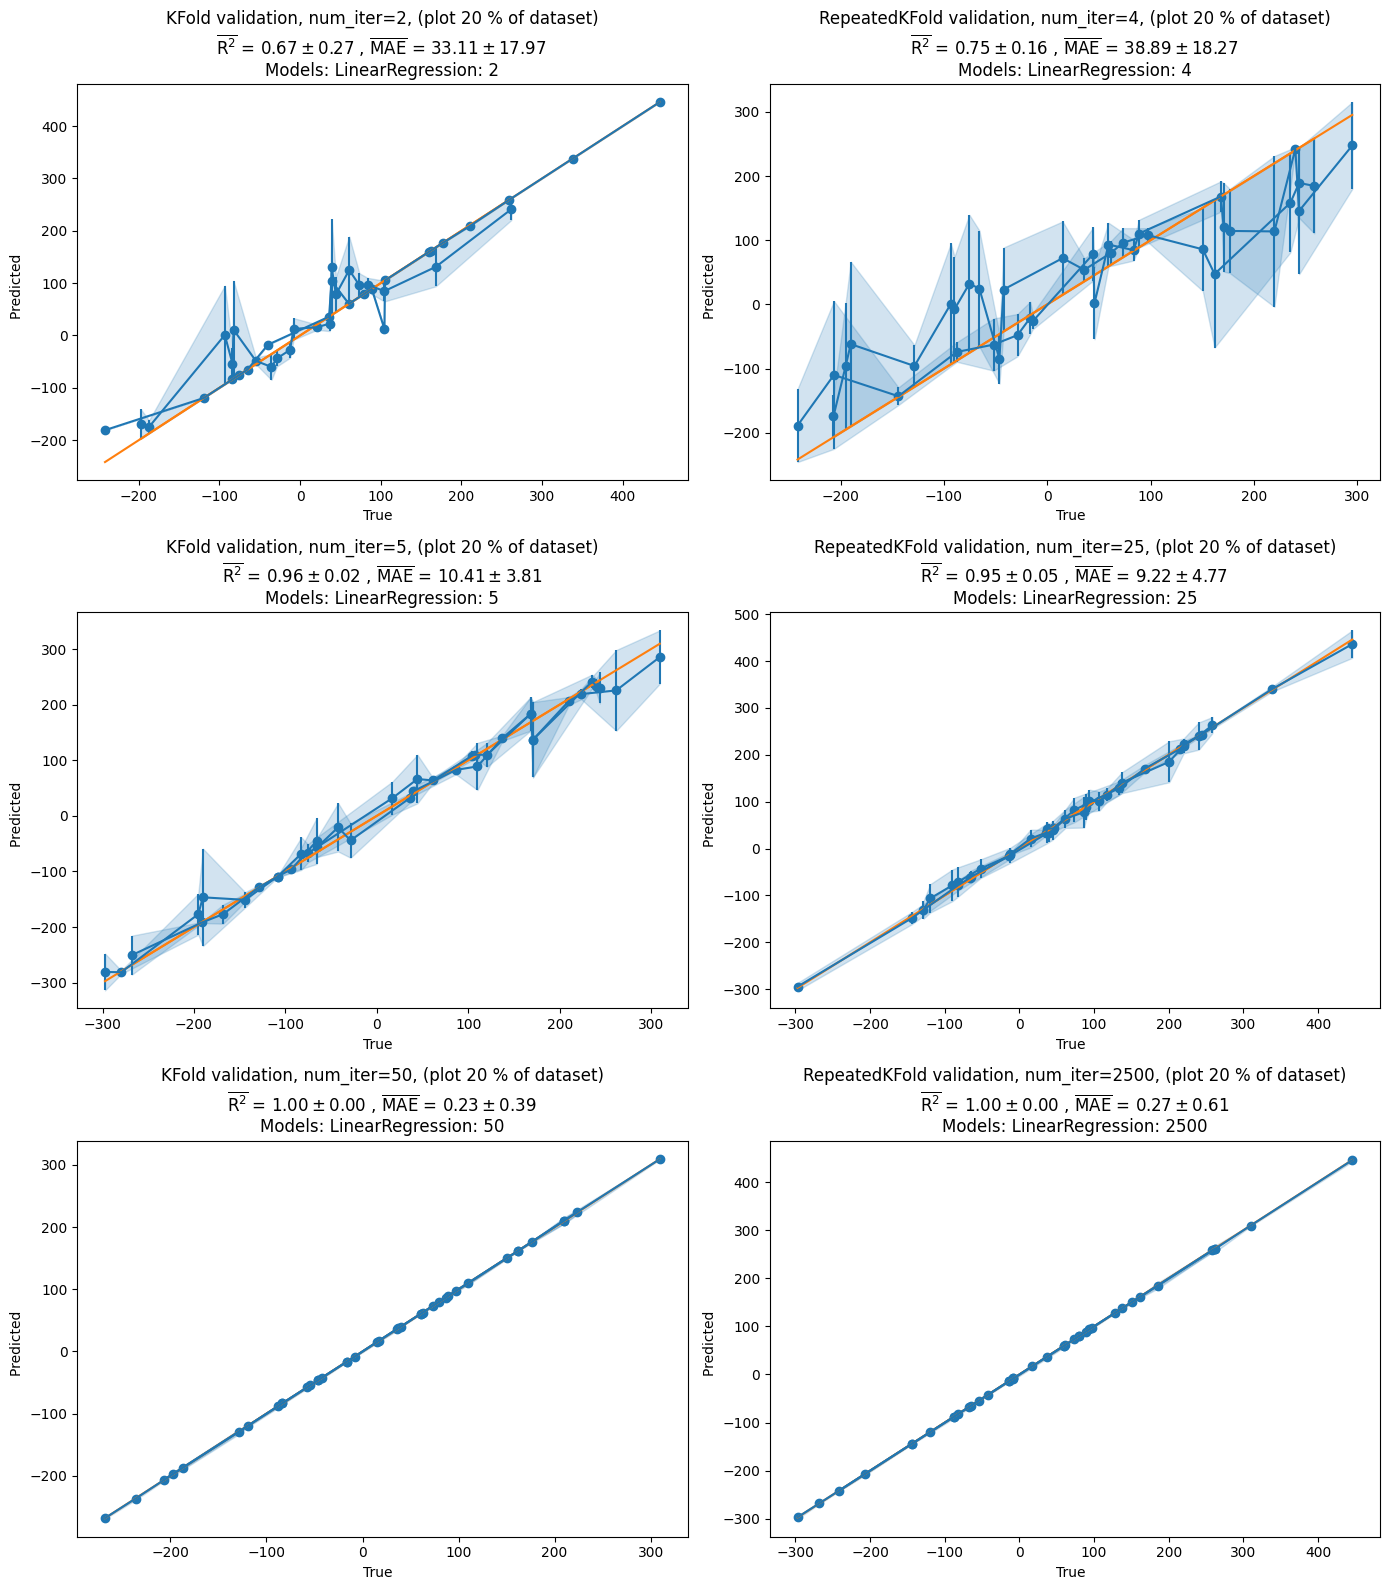

In [19]:
fig

## Nested k-Fold for hyperopt

Main reference for quotes and implementation:

- https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

> Nested cross-validation is an approach to model hyperparameter optimization and model selection that attempts to overcome the problem of overfitting the training dataset. [...] The k-fold cross-validation procedure for model hyperparameter optimization is nested inside the k-fold cross-validation procedure for model selection. The use of two cross-validation loops also leads the procedure to be called “double cross-validation.”

The normal K-fold CV for model selection is here called the "outer CV". On each train set of this iteration, the train set is again split K-fold times into an "inner train" and a "validation set" (to distinguish the inner test set from the outer test set). In this inner KCV, the hyperparam search is performed with a hyperopt algo, like grid search etc.

> Under this procedure, hyperparameter search does not have an opportunity to overfit the dataset as it is only exposed to a subset of the dataset provided by the outer cross-validation procedure. This reduces, if not eliminates, the risk of the search procedure overfitting the original dataset and should provide a less biased estimate of a tuned model’s performance on the dataset.

Downside: double loop -> expensive. If classical KCV is used for hyperopt, $K \cdot C$ models are evaluated ($K$ = num. splits of the KCV, $C$ = num. hyperparam sets /configs to try = num. hyperparam grid points). Nested KCV adds an outer KCV loop to this, so you end up with evaluating $K^2 \cdot C$ models. E.g., let $K_{inner} = 5$, $C = 100$, $K C = 500$, and $K_{outer} = 10$, so $K_{outer} K_{inner} C = 5000$.

> It is common to use k=10 for the outer loop and a smaller value of k for the inner loop, such as k=3 or k=5.

How is the "final model" created?

> 1. An algorithm is selected based on its performance on the outer loop of nested cross-validation.
> 2. Then the inner-procedure is applied to the entire dataset.
> 3. The hyperparameters found during this final search are then used to configure a final model.
> 4. The final model is fit on the entire dataset.


![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Nested-k-fold-CV-1.png?ssl=1)

**CAUTION WIP FROM HERE ON, NOT WORKING YET!!!**

In [ ]:
# create dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=1, n_informative=10, n_redundant=10)

In [38]:
do_timing

True

In [ ]:
@timeit
def nested_kfold_crossval_v1(X , y, n_jobs=-1):
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
    # enumerate splits
    outer_results = list()
    for train_ix, test_ix in cv_outer.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        # define the model
        model = RandomForestClassifier(random_state=1)
        # define search space
        space = dict()
        space['n_estimators'] = [10, 100, 500]
        space['max_features'] = [2, 4, 6]
        # define search
        search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True, n_jobs=n_jobs)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
        # store the result
        outer_results.append(acc)
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

In [7]:
@conditional_decorator(dec=timeit_decorator, condition=do_timing)
def nested_kcv_v2(X,y,n_jobs=1):
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier(random_state=1)
    # define search space
    space = dict()
    space['n_estimators'] = [10, 100, 500]
    space['max_features'] = [2, 4, 6]
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', n_jobs=n_jobs, cv=cv_inner, refit=True, verbose=3)
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
    # execute the nested cross-validation
    scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=n_jobs, verbose=3)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [53]:
class NestedKFold(KFold):
    def __init__(self, cv_outer : BaseCrossValidator, cv_inner : BaseCrossValidator, model_cls : type, grid : dict, searcher_cls : type, model_kwargs : dict=None, searcher_kwargs:dict=None, **kwargs):
        super().__init__(**kwargs)
        self.cv_outer = cv_outer
        self.cv_inner = cv_inner
        self.model_cls = model_cls
        self.searcher_cls = searcher_cls
        self.mmodel_kwargs = model_kwargs if model_kwargs else dict()
        self.searcher_kwargs = searcher_kwargs if searcher_kwargs else dict()
        
    def run(n_jobs=-1):
        

In [ ]:
GridSearchCV(

In [75]:
class NestedKFold_v2(KFold):
    def __init__(self, cv_outer : BaseCrossValidator, cv_inner : BaseCrossValidator, model_cls : type, grid : dict, searcher_cls : type, model_kwargs : dict=None, searcher_kwargs:dict=None, **kwargs):
        super().__init__(**kwargs)
        self.cv_outer = cv_outer
        self.cv_inner = cv_inner
        self.model_cls = model_cls
        self.grid = grid
        self.searcher_cls = searcher_cls
        self.model_kwargs = model_kwargs if model_kwargs else dict()
        self.searcher_kwargs = searcher_kwargs if searcher_kwargs else dict()
        
    def run(self, X, y, n_jobs=-1):
        model = self.model_cls(**(self.model_kwargs))
        search = self.searcher_cls(estimator=model, param_grid=self.grid, **(self.searcher_kwargs))
        scores = cross_val_score(search, X, y, scoring='accuracy', cv=self.cv_outer, n_jobs=n_jobs, verbose=3)
        print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
        

In [76]:
X,y = make_regression()

In [77]:
nkf = NestedKFold_v2(KFold(), KFold(), KernelRidge, grid={'alpha':[0.01,0.1,0.5],'kernel':['linear', 'rbf']}, searcher_cls=GridSearchCV, searcher_kwargs=None)

In [ ]:
nkf.run(X,y,n_jobs=1)

Equivalent nested KCV, using `cross_val_score` instead --> less code. Also, it's ~10x faster. Disadvantage: inner CV message printings are not accessible.

In [5]:
do_timing = True

In [ ]:
_ = nested_kcv_v2(X,y,-1)